# Testing the Stock Forecasting Model

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) we derived a mathematical model for long-term forecasting of stock returns. We plotted the model's forecasted returns along with historical data for the S&P 500 stock-market index and some individual stocks. For short investment periods up to about 3-4 years, the forecasting model seemed to fit the historical data quite poorly, but it often seemed to fit the data very well for longer investment periods of e.g. 10 years.

In this paper we present more formal methods for measuring how well the forecasting model fits the historical data. We also perform statistical hypothesis testing so as to assess whether the forecasting model is really an improvement over just using the historical data's mean and standard deviation.

It is recommended that you are familiar with the previous papers before reading this.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_stock_data
from returns import prepare_ann_returns, reinvestment_growth

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_JNJ = "JNJ"
ticker_K = "K"
ticker_PG = "PG"
ticker_WMT = "WMT"

In [5]:
# Load the financial data for the stocks.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_JNJ = load_stock_data(ticker=ticker_JNJ)
df_K = load_stock_data(ticker=ticker_K)
df_PG = load_stock_data(ticker=ticker_PG)
df_WMT = load_stock_data(ticker=ticker_WMT)

In [6]:
df_JNJ[DIVIDEND_YIELD] = reinvestment_growth(df_JNJ)
df_K[DIVIDEND_YIELD] = reinvestment_growth(df_K)
df_PG[DIVIDEND_YIELD] = reinvestment_growth(df_PG)
df_WMT[DIVIDEND_YIELD] = reinvestment_growth(df_WMT)

## Mathematical Model

Let us define the Total Return of a stock at time-step $t$ as the number of shares which may grow from reinvestment of dividends (taxes are ignored), multiplied by the share-price:

$$
Total\ Return_t = Shares_t \cdot Share\ Price_t
$$

The annualized return between the start-date $t$ and the end-date $t+Years$ is defined as:

$$
Ann\ Return_t
= \left( \frac{Total\ Return_{t+Years}}{Total\ Return_t} \right) ^ {1/Years} - 1
$$

From this definition, the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) derived two formulas for the mean and standard deviation of the annualized return given the P/Sales ratio at time-step $t$:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}}
$$

where the parameters $a$ and $b$ can be estimated from three factors: (1) The growth in the number of shares from reinvestment of dividends, (2) the growth in Sales Per Share, and (3) the change in the P/Sales valuation ratio. The parameters are estimated as:

$$
a \simeq E[Dividend\ Yield + 1]
\cdot E[Sales\ Per\ Share\ Growth + 1]
\cdot E[ P/Sales ^ {1/Years} ]
$$

$$
b \simeq Std \left[ (Dividend\ Yield + 1) \cdot (Sales\ Per\ Share\ Growth + 1) \cdot P/Sales ^ {1/Years} \right]
$$

Forecasting the future return on a stock can therefore be split into forecasting these three factors. We can use historical values for the dividend yield, sales growth, and P/Sales ratios, or we can use other numbers if we think the future will be different from the past.

## Goodness of Fit

The above formulas produce curves that will be plotted further below, showing how the forecasted annualized return varies with $P/Sales_t$. We are now interested in measuring how well these forecasted curves fit the actual historical observations. Let us first introduce some more compact notation.

Let $(x_t, y_t)$ be a pair of historical observations for time-step $t$ so that $x_t = P/Sales_t$ and $y_t = Ann\ Return_t$. The stochastic variable $X$ is for the P/Sales ratio and the associated variable $Y$ is for the annualized return.

The mean of the historically observed annualized return is denoted $\bar{Y}$ and calculated as:

$$
\bar{Y} = \frac{1}{n} \sum_{t=1}^n y_t
$$

Let $\hat{\mu}_t$ be the mean annualized return estimated from the above formula for $E[Ann\ Return_t]$ given $P/Sales_t = x_t$ and some choice of parameter $a$. Similarly let $\hat{\sigma}_t$ be the standard deviation for the annualized return estimated from the above formula for $Std[Ann\ Return_t]$ given $P/Sales_t = x_t$ and some choice of parameter $b$.

We will use 4 different measures of how well the annualized return forecasted by $\hat{\mu}_t$ and $\hat{\sigma}_t$ fit the actual historical observations $y_t$.

- Mean Squared Error (MSE) is a common measure of how well predicted values fit actual observations. It is defined as:
$$
MSE = \frac{1}{n} \sum_{t=1}^n \left( y_t - \hat{\mu}_t \right)^2
$$
The MSE is non-negative with smaller values meaning a better fit. An MSE of zero means a perfect fit without any errors between actual and predicted observations. But because the errors are squared, it means that larger errors may dominate the overall error measure. Furthermore, the squared errors make interpretation difficult.

- Mean Absolute Error (MAE) is another common measure of how well predicted values fit actual observations. Because it uses the absolute instead of squared errors, it is easier to interpret than MSE. It is defined as:
$$
MAE = \frac{1}{n} \sum_{t=1}^n \left| y_t - \hat{\mu}_t \right|
$$
The MAE is also non-negative with lower values meaning better fits and zero MAE is a perfect fit.

- Mean Absolute Z-Score (MAZ) is probably not the right name for this statistic, but the idea is to compare both the forecasted mean and standard deviation to the actual observations, unlike the MSE and MAE which only use the forecasted mean. The MAZ is calculated as the average number of forecasted standard deviations that the actual observations are from the forecasted mean. The formula is:
$$
MAZ = \frac{1}{n} \sum_{t=1}^n \frac{\left| y_t - \hat{\mu}_t \right|}{\hat{\sigma}_t}
$$
The MAZ is also non-negative, but it is harder to interpret because we want low MAZ values - but not too low. We can have a value of zero for the MAZ if either the forecasted mean $\hat{\mu}_t$ perfectly fits the observed data $y_t$, or when $\hat{\sigma}_t \rightarrow \infty$ so that $MAZ \rightarrow 0$ but that does not mean a good fit of the model to the data. We will discuss this further below.

- Coefficient of Determination $R^2$ usually measures how much of the variance in the observed data is explained by the model. It is defined from the Sum of Squared Errors (SSE) between the forecasted mean $\hat{\mu}_t$ and actual observations $y_t$, relative to the Sum of Squared Errors Total (SST) between the actual observations $y_t$ and their mean $\bar{Y}$:
$$
R^2 = 1 - \frac{SSE}{SST} =
\frac{\sum_{t=1}^n \left( y_t - \hat{\mu}_t \right)^2}{\sum_{t=1}^n \left( y_t - \bar{Y} \right)^2}
$$
The $R^2$ usually goes from 0 to 1, with 0 meaning the model does not explain any of the variance in the data, and 1 meaning that the model fits the data perfectly and therefore explains all of the variance in the data. However, because we have a non-linear model, the SSE may be greater than the SST, so $R^2$ can become negative when there is great variance in the data and the non-linear model fits poorly.

## Hypothesis Testing

The Goodness of Fit is calculated for samples of historical observations which originate from some random process. We would like to *prove* that the mathematical model is *correct* but that is not possible using statistical methods. All we can do is compare our model's Goodness of Fit to some baseline model, so as to assess whether our model is an improvement. For the baseline we will just use the mean annualized return from the historical observations. So we want to know if our model predicts the annualized return better than the average of that data.

But even if our model fits the data better than the baseline, how can we be certain that it is not just a random coincidence in this particular sample of data? Perhaps if we took more samples, the model would no longer fit the data better than the baseline. That is what Statistical Hypothesis Testing is about.

We will start by assuming our model fits the historical data just as well as the baseline, so that their MSE values are equal. This is called the null-hypothesis and is denoted $H_0$. We will then conduct a hypothesis test by calculating the so-called p-value, which is the probability of observing these particular MSE values for the model and the baseline, if indeed the MSE values were equal. This calculation takes into account the difference in MSE values, the variance in the data, and the number of data-points.
A p-value close to zero means that it is highly unlikely that we would observe those particular MSE values, if indeed they were identical, so we can reject the null-hypothesis $H_0$ and instead accept the alternative hypothesis $H_a$ that the MSE values are most likely different, and hence our model is either better or worse than the baseline.

We will be using a so-called *paired t-test* for comparing our model's fit to that of the baseline. We do this by calculating the residual errors for our model and the baseline, such as the squared error or the absolute error, and then we use the paired t-test on these errors to assess whether the means are equal or not.

When using the paired t-test, we are comparing whether our model's error $(y_t - \hat{\mu}_t)^2$ is different from the baseline's error $(y_t - \bar{Y})^2$ on average. This is a stronger test than the un-paired or independent t-test which only compares the overall means. But you could argue that it doesn't really matter, because we are just interested in comparing the overall fit of the model and the baseline.

The t-test also makes a number of assumptions about the data and sampling procedure concerning randomness, independence, etc. These assumptions may not be entirely satisfied because of the strong correlation between data-points that are close in time. So the results of the t-test should be interpreted with some caution.

However, a much greater problem is that the results of the t-test do not imply that the model can be used to forecast the future stock returns. That will depend entirely on the stock's future dividend yield, sales-growth and P/Sales distribution. This is ultimately a qualitative question which a statistical test cannot answer, as discussed further below.

## Implementation

This class implements the forecasting model and the statistical testing from above.

In [7]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term stock returns.
    """

    def __init__(self, dividend_yield, sales_growth,
                 psales, years):
        """
        Create a new model and fit it with the given data.
        
        :param dividend_yield: Array with dividend yields.
        :param sales_growth: Array with one-year sales growth.
        :param psales: Array with P/Sales ratios.
        :param years: Number of years.
        """
        
        # Copy args to self.
        # Note the +1 for dividend yield and sales-growth
        # so we don't have to do it several times below.
        self.dividend_yield = np.array(dividend_yield) + 1
        self.sales_growth = np.array(sales_growth) + 1
        self.psales = psales
        self.years = years
        
        # Calculate the `a` parameter for the mean ann.return.
        self.a = self.mean_parameter()

        # Calculate the `b` parameter for the std.dev. ann.return.
        self.b = self.std_parameter()

    def forecast(self, psales_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future stock returns.
        
        :param psales_t: Array with different P/Sales ratios at buy-time.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the psales_t values.
        """

        # Annualized psales_t which is used in both formulas.
        psales_t_ann = psales_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of P/Sales ratios at the
        # time of buying the stock.
        mean = self.a / psales_t_ann - 1.0
        std = self.b / psales_t_ann

        return mean, std

    def mean_parameter(self):
        """
        Estimate the parameter `a` used in the formula for the
        mean annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        :return: The parameter `a` for the mean return formula.
        """

        # We assume dividend_yield and sales_growth is already +1.
        a = np.mean(self.dividend_yield) \
          * np.mean(self.sales_growth) \
          * np.mean(self.psales ** (1/self.years))

        return a

    def std_parameter(self, num_samples=10000):
        """
        Estimate the parameter `b` used in the formula for the
        std.dev. annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        This is estimated using Monte Carlo simulation / resampling
        of the given data, which is assumed to be independent of
        each other and over time.

        :param num_samples: Number of Monte Carlo samples.
        :return: The parameter `b` for the std.dev. return formula.
        """

        # We will do a Monte Carlo simulation / resampling
        # from the supplied arrays of data. For each year
        # we take e.g. 10k random samples and then we
        # calculate the annualized growth-rates. This gives
        # us different values for dividend yields and sales-growth
        # for each year, instead of just taking one random
        # number and using that for all the years.

        # Shape of arrays to sample.
        shape = (num_samples, self.years)
        num_samples_total = np.prod(shape)

        # Sample the dividend yield. We assume it is already +1.
        dividend_yield_sample = np.random.choice(self.dividend_yield, size=shape)
        # Compound the growth through the years.
        dividend_yield_sample = np.prod(dividend_yield_sample, axis=1)

        # Sample the sales-growth. We assume it is already +1.
        sales_growth_sample = np.random.choice(self.sales_growth, size=shape)
        # Compound the growth through the years.
        sales_growth_sample = np.prod(sales_growth_sample, axis=1)

        # Sample the P/Sales ratio at the time of selling.
        psales_sample = np.random.choice(self.psales, size=num_samples)

        # Combine the three samples.
        combined_sample = dividend_yield_sample * sales_growth_sample * psales_sample

        # Calculate the `b` parameter.
        b = np.std(combined_sample ** (1/self.years))

        return b
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MSE(self, psales_t, ann_rets):
        """
        Calculates the Mean Squared Error (MSE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MSE between the baseline and the
        observed annualized returns.

        Also calculates the p-value that the forecasted and
        baseline MSE values are equal.

        :param psales_t:
            Array with different P/Sales ratios at buy-time.

        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mse_forecast: MSE between model's forecast and actual returns.
            mse_baseline: MSE between baseline and actual returns.
            p_value: p-value whether the two MSE values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Mean Squared Errors (MSE).
        mse_forecast = np.mean(err_forecast)
        mse_baseline = np.mean(err_baseline)

        # Hypothesis test whether the two MSE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mse_forecast, mse_baseline, p_value

    def MAE(self, psales_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def MAZ(self, psales_t, ann_rets):
        """
        Calculates the Mean Absolute Z-Score (MAZ) between the
        model's forecasted mean and the observed annualized returns.
        
        The MAZ is the average distance between the forecasted
        mean and the observed annualized returns, measured in
        terms of the forecasted std.dev.

        Also calculates the MAZ between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAZ values are equal.
        
        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAZ between model's forecast and actual returns.
            mae_baseline: MAZ between baseline and actual returns.
            p_value: p-value whether the two MAZ values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast) / std_forecast
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets)) / np.std(ann_rets)
        
        # Mean Absolute Z-Scores (MAZ).
        maz_forecast = np.mean(err_forecast)
        maz_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAZ values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return maz_forecast, maz_baseline, p_value
    
    def R_squared(self, psales_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of one means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

## Print Statistics

This helper-function prints the various statistics for a forecasting model.

In [8]:
def print_statistics(model, psales_t, ann_rets):
    """
    Calculate and print the Goodness of Fit statistics
    for a model's forecast compared to the baseline.

    The p-value results from a paired t-test whether
    the values are equal. A p-value close to zero means
    that the values are unlikely to be equal.

    :param model:
        Instance of the ForecastModel class.

    :param psales_t:
        Array with different P/Sales ratios at buy-time.

    :param ann_rets:
        Array with the corresponding annualized returns.
    """
    
    # Print header.
    print("\tForecast\tBaseline\tp-value")
    print("=================================================")

    # Mean Absolute Error (MAE).
    mae_forecast, mae_baseline, p_value = model.MAE(psales_t=psales_t,
                                                    ann_rets=ann_rets)
    msg = "MAE:\t{0:.1%}\t\t{1:.1%}\t\t{2:.2e}"
    msg = msg.format(mae_forecast, mae_baseline, p_value)
    print(msg)

    # Mean Squared Error (MSE).
    mse_forecast, mse_baseline, p_value = model.MSE(psales_t=psales_t,
                                                    ann_rets=ann_rets)
    msg = "MSE:\t{0:.2e}\t{1:.2e}\t{2:.2e}"
    msg = msg.format(mse_forecast, mse_baseline, p_value)
    print(msg)
    
    # Mean Absolute Z-Score (MAZ).
    maz_forecast, maz_baseline, p_value = model.MAZ(psales_t=psales_t,
                                                    ann_rets=ann_rets)
    msg = "MAZ:\t{0:.2f}\t\t{1:.2f}\t\t{2:.2e}"
    msg = msg.format(maz_forecast, maz_baseline, p_value)
    print(msg)

    # R^2.
    R_squared = model.R_squared(psales_t=psales_t,
                                ann_rets=ann_rets)
    msg = "R^2:\t{0:.2f}"
    msg = msg.format(R_squared)
    print(msg)

## Plotting Function

This is the helper-function for plotting the historical annualized returns and overlay them with the mean and standard deviation of the forecasting model.

In [9]:
def plot_ann_returns(ticker, df, years,
                     dividend_yield=None, sales_growth=None,
                     psales=None,
                     psales_min=None, psales_max=None):
    """
    Create a plot with the actual historical returns showing
    the P/Sales ratios vs. future Annualized Returns. Overlay
    this plot with the estimated mean and std.dev. from the
    mathematical forecasting model we have derived above.
    
    The optional params are taken from the DataFrame `df`
    if not supplied. This allows you to override some or
    all of the data used in the forecasting model e.g.
    to change assumptions about future sales-growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param dividend_yield: (Optional) Array with dividend yields.
    :param sales_growth: (Optional) Array with one-year sales growth.
    :param psales: (Optional) Array with P/Sales ratios.
    :param psales_min: (Optional) Min P/Sales for plotting curves.
    :param psales_max: (Optional) Max P/Sales for plotting curves.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()

    # Get Dividend Yield if none provided.
    if dividend_yield is None:
        dividend_yield = df2[DIVIDEND_YIELD]

    # Get Sales Growth if none provided.
    if sales_growth is None:
        sales_growth = df2[SALES_GROWTH]

    # Get P/Sales if none provided.
    if psales is None:
        psales = df2[PSALES]

    # Get min P/Sales for plotting if none provided.
    if psales_min is None:
        psales_min = np.min(psales)
    
    # Get max P/Sales for plotting if none provided.
    if psales_max is None:
        psales_max = np.max(psales)
        
    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=dividend_yield,
                          sales_growth=sales_growth,
                          psales=psales, years=years)
    
    # Evenly spaced P/Sales ratios between historic min and max.
    psales_t = np.linspace(start=psales_min, stop=psales_max, num=100)

    # Use the model to forecast the mean and std ann.returns.
    mean, std = model.forecast(psales_t=psales_t)

    # Plot the mean ann.return.
    ax.plot(psales_t, mean, color="black", label="Forecast Mean")
    
    # Plot one standard deviation.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(psales_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(psales_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)
    
    # Plot two standard deviations.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(psales_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(psales_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(psales_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Get the actual ann.returns from the historic data.
    x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)
    
    # Scatter-plot with the actual P/Sales vs. Ann.Returns.
    ax.scatter(x, y, label="Actual Returns")

    # Plot baseline mean as horizontal dashed line.
    ax.axhline(y=np.mean(y), color="black", linestyle="--",
               label="Baseline")

    # Show the labels for what we have just plotted.
    ax.legend()

    # Create plot-title.
    # First part of the title.
    title1 = "[{0}] {1}-Year Ann. Return".format(ticker, years)
    # Second part of the title. Formula for mean ann. return.
    msg = "E[Ann Return] = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[Ann Return] = {0:.3f} / (P/Sales ^ (1/{1}))"
    title3 = msg.format(model.b, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    # Set axes labels.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Show grid.
    ax.grid()
    
    # Show the plot.
    plt.show()
    
    # Print the Goodness of Fit statistics.
    print_statistics(model=model, psales_t=x, ann_rets=y)

## Case Study: S&P 500

The S&P 500 is a stock-market index consisting of the stocks of 500 of the largest companies in USA. The S&P 500 covers about 80% of the whole U.S. stock-market in terms of size so it is useful as a gauge for the entire U.S. stock-market.

Because of the broad diversification of the S&P 500 index, we would expect the forecasting model to work better on the S&P 500 than on many individual companies.

### S&P 500 - 1 Year Returns

We now use the forecasting model on the historical data for the S&P 500 between 1989 and 2017. The plot shows the actual one-year returns of the S&P 500 as blue dots. The forecasted mean return is the black line. The green area is one forecasted standard deviation around the mean, and the red area is two standard deviations. The dashed black line is the baseline used for comparison and it is just the mean annualized return for the historical data.

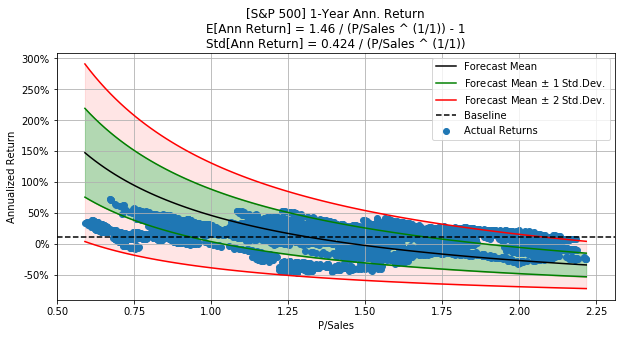

	Forecast	Baseline	p-value
MAE:	28.5%		12.2%		0.00e+00
MSE:	1.40e-01	2.75e-02	0.00e+00
MAZ:	0.80		0.73		2.05e-14
R^2:	-4.08


In [10]:
plot_ann_returns(years=1, ticker=ticker_SP500, df=df_SP500)

The statistics above show that the forecasting model fits the historical data much worse than the baseline average. The MSE can be a bit hard to interpret, but the MAE shows us that on average, the absolute error of the forecasting model is 28.5% while it is only 12.2% for the baseline. The p-value is practically zero which means this difference did not happen by random chance. We can therefore conclude, that the forecasting model fits the historical data much worse than the average return, for 1-year investment periods of the S&P 500.

Also note that the $R^2$ is negative because the variance is high for the data and the non-linear forecasting model fits the data poorly.

### S&P 500 - 4 Year Returns

For 2 and 3 year periods, the forecasting model also fits the data worse than the average annualized return, so those plots have been omitted.

The following plot shows the annualized return for all 4-year periods of the S&P 500, along with the forecasted mean and standard deviation.

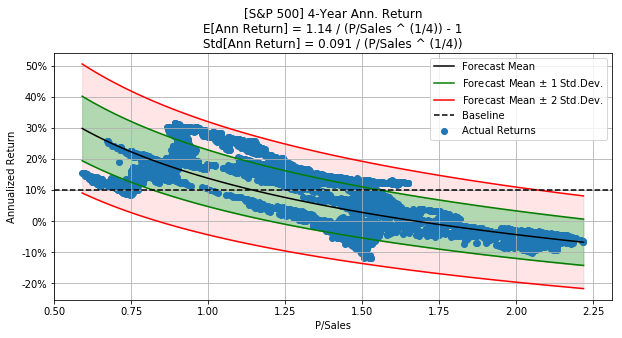

	Forecast	Baseline	p-value
MAE:	6.5%		8.5%		2.11e-164
MSE:	5.84e-03	9.94e-03	6.11e-256
MAZ:	0.74		0.85		1.96e-51
R^2:	0.41


In [11]:
plot_ann_returns(years=4, ticker=ticker_SP500, df=df_SP500)

The above plot suggests that the forecasting model is a better fit than the baseline, but we would like to quantify exactly how much better, which is shown by the above statistics. The MAE is 6.5% for the forecasting model while it is 8.5% for the baseline. So the forecasting model has a better fit with the absolute error being about 2 percentage points on average. The p-value is practically zero, which means that it is extremely unlikely this happened by random chance. However, the $R^2$ is 0.41 which means that most of the variance in the data is not explained by the forecasting model.

### S&P 500 - 10 Year Returns

This plot shows the actual returns of the S&P 500 for all 10-year investment periods between 1989 and 2017, which are almost all within one standard deviation of the forecasted mean, so the forecasting model fits the historical data quite well.

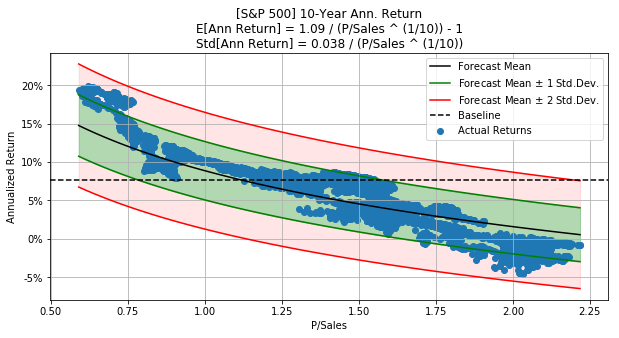

	Forecast	Baseline	p-value
MAE:	2.1%		3.5%		1.10e-277
MSE:	5.86e-04	2.37e-03	0.00e+00
MAZ:	0.56		0.72		1.99e-90
R^2:	0.75


In [12]:
plot_ann_returns(years=10, ticker=ticker_SP500, df=df_SP500)

The above statistics show that the forecasting model has a MAE of 2.1% which is significantly lower than the baseline's MAE of 3.5%. The p-value is nearly zero so this difference is not due to random chance. The $R^2$ is 0.75 which means that a significant part of the data's variance is now explained by the forecasting model.

Also note the MAZ value of 0.57, which means that on average, the observed data lies 0.57 forecasted standard deviations from the forecasted mean. Unfortunately the MAZ value is not enough on its own to assess whether the model has a good fit, as shown next.

## Case Study: Procter & Gamble (PG)

Let us now consider an individual company called Procter & Gamble which has the ticker symbol PG. It sells a wide range of consumer products and has almost 100.000 employees.

### PG - 1 Year Returns

The following plot shows all 1-year returns of PG between 1994 and 2017. It looks like the model fits the data reasonably well - but this is deceptive because the variance is so high, as we will see from the statistics below.

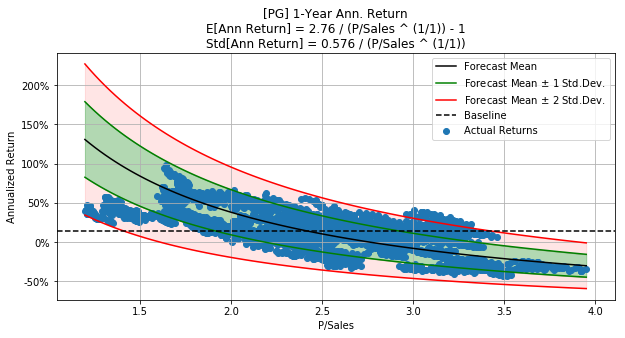

	Forecast	Baseline	p-value
MAE:	16.0%		14.4%		4.59e-17
MSE:	4.70e-02	3.96e-02	3.69e-09
MAZ:	0.64		0.72		1.63e-23
R^2:	-0.19


In [13]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=1)

The above statistics show us that the forecasting model's mean is actually slightly worse than the baseline. The forecasting model has a MAE of 16.0% while the baseline has a MAE of 14.4%. The p-value is nearly zero so this difference is not due to random chance.

However, consider the MAZ values which take both the forecasted mean and standard deviation into account. The forecasting model has a MAZ of about 0.6 while the baseline has a MAZ of about 0.7, so the forecasting model fits the whole distribution slightly better than the baseline, and the p-value near zero tells us this difference is not due to random chance.

Also note the negative $R^2$ value which is caused by the forecasting model's poor fit to the high-variance data.

Overall the forecasting model is not very accurate for 1-year returns of the PG stock.

### PG - 2 Year Returns

The following plot shows the actual returns of the PG stock for all 2-year periods between 1994 and 2017, which mostly fit within 1 standard deviation of the forecasted mean. This is a really good fit for such a short investment period.

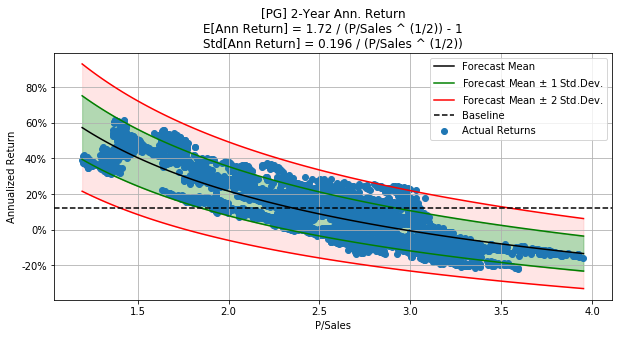

	Forecast	Baseline	p-value
MAE:	6.9%		11.2%		3.60e-302
MSE:	7.08e-03	2.33e-02	0.00e+00
MAZ:	0.54		0.73		1.75e-126
R^2:	0.70


In [14]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=2)

The above statistics show that the MAE is 6.9% for the forecasting model while it is much higher at 11.2% for the baseline. The p-value is nearly zero so this difference is not due to random chance. The $R^2$ value is 0.70 which means that a significant part of the data's variance is explained by the forecasting model. This is quite remarkable for such a short investment period.

### PG - 5 Year Returns

This plot shows the actual returns of the PG stock for all 5-year periods, which also mostly fit within one standard deviation of the forecasted mean.

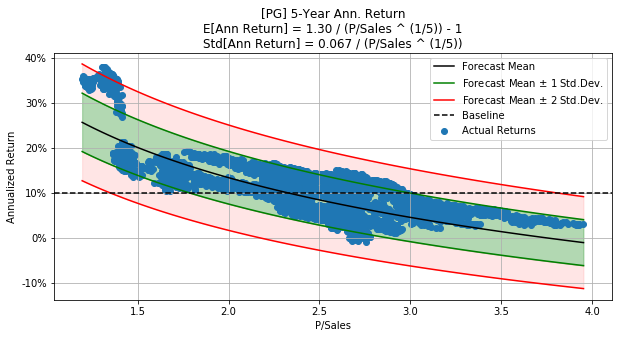

	Forecast	Baseline	p-value
MAE:	3.1%		4.6%		7.80e-270
MSE:	1.49e-03	4.26e-03	5.93e-130
MAZ:	0.54		0.71		4.39e-135
R^2:	0.65


In [15]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=5)

The statistics above show that the MAE is 3.1% for the forecasting model, while it is 4.6% for the baseline. The p-value is nearly zero so this difference is not due to random chance.

Note that the $R^2$ is now 0.65 which is slightly less than the 0.70 for 2-year investment periods above. Although the MSE of the forecasting model is lower for these 5-year investment periods than for 2-year periods, the baseline's MSE is also much lower, and the $R^2$ is a measure of how the forecasting model's MSE relates to the baseline's MSE.

### PG - 10 Year Returns

This plot shows the actual returns of the PG stock for all 10-year periods, which also mostly fit within one standard deviation of the forecasted mean.

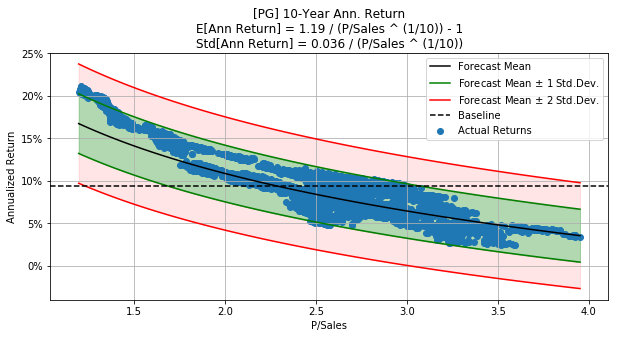

	Forecast	Baseline	p-value
MAE:	1.2%		3.0%		0.00e+00
MSE:	2.48e-04	1.50e-03	0.00e+00
MAZ:	0.37		0.78		0.00e+00
R^2:	0.83


In [16]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=10)

The statistics above show that the MAE is only 1.2% for the forecasting model, while it is 2.5 times as high for the baseline at 3.0%. The p-value is practically zero so this difference is not due to random chance. The MAZ for the baseline model is also about twice as high compared to the forecasting model. The $R^2$ is 0.83 which means that a substantial part of the data's variance is explained by the forecasting model.

## Case Study: Wal-Mart (WMT)

Now let us consider the company Wal-Mart which trades under the ticker symbol WMT. It is an extremely large retail-company with about 2.3 million employees.

### WMT - 1 Year Returns

This plot shows the actual returns of the WMT stock for all 1-year periods between 1972-2017. Although we noted in the previous paper that there might be data-errors for earlier parts of this time-range, we will still use all the data because we deliberately want to show the statistics for very poor fits of the forecasting model.

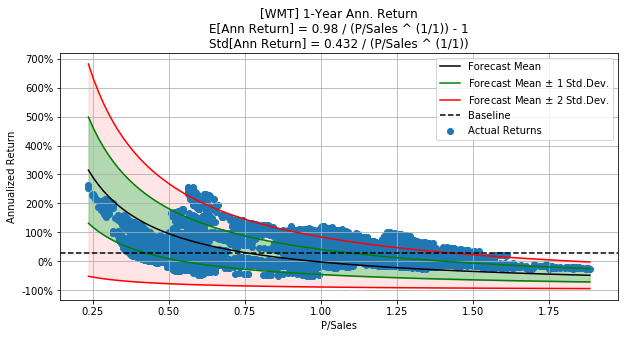

	Forecast	Baseline	p-value
MAE:	58.1%		30.2%		0.00e+00
MSE:	4.49e-01	1.61e-01	0.00e+00
MAZ:	0.93		0.75		3.72e-164
R^2:	-1.79


In [17]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, years=1)

The statistics above show a very poor fit of the forecasting model with a MAE of 58.1% while the baseline has a MAE of 30.2%. The p-value is practically zero so this difference is not due to random chance. Also note that the MAZ is higher for the forecasting model, and that the $R^2$ is negative because the data has very high variance and the forecasting model fits the data so poorly.

So the statistics show us that the forecasting model fits the historical data very poorly for 1-year investment periods of the WMT stock.

### WMT - 3 Year Returns

This plot shows the actual returns of the WMT stock for all 3-year periods. It is unclear from the plot whether the forecasting model or the baseline is a better fit, so we need proper statistics to assess this.

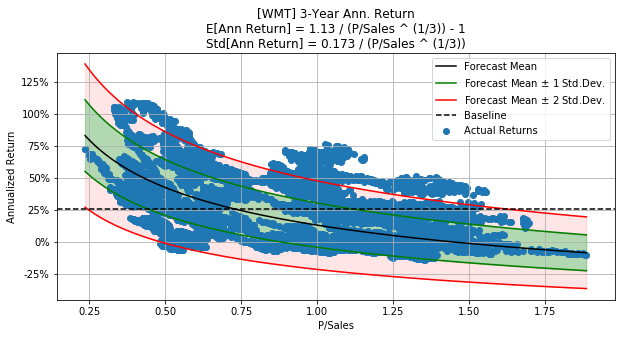

	Forecast	Baseline	p-value
MAE:	21.8%		21.4%		3.05e-03
MSE:	6.46e-02	6.30e-02	1.38e-02
MAZ:	1.12		0.85		0.00e+00
R^2:	-0.03


In [18]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, years=3)

The statistics above show that the MSE and MAE are very close for the forecasting model and baseline. The MSE is slightly higher for the forecasting model and the p-value is 0.0138 which means that the small difference might be due to random chance, although the probability of that is quite low.

The MAE is also slightly higher for the forecasting model, but now the p-value is 0.00305 so it is even less likely that the difference is due to random chance.

The MAZ is significantly higher for the forecasting model than for the baseline, which means that the entire distribution of annualized returns might be better described by its mean and standard deviation than by the forecasting model.

The $R^2$ is also slightly negative.

Overall the forecasting model fits the data slightly worse than the mean and standard deviation for the annualized returns.

### WMT - 10 Year Returns

This plot shows the actual returns of the WMT stock for all 10-year periods.

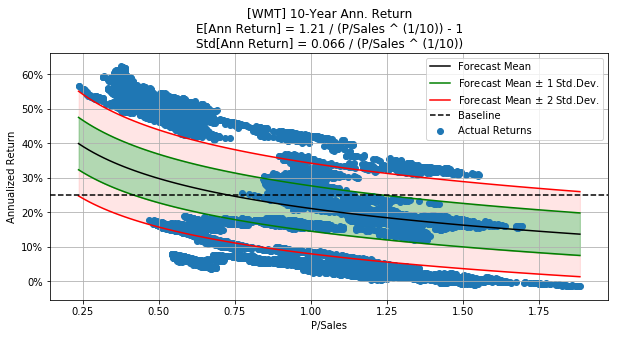

	Forecast	Baseline	p-value
MAE:	13.4%		15.8%		0.00e+00
MSE:	2.32e-02	3.29e-02	0.00e+00
MAZ:	1.97		0.87		0.00e+00
R^2:	0.30


In [19]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, years=10)

The above statistics show that the MSE and MAE are somewhat lower for the forecasting model compared to the baseline, and the p-values are practically zero so this difference is not due to random chance.

However, the MAZ is about 2.0 for the forecasting model while it is only 0.87 for the baseline, which means that the forecasted standard deviation is probably much too narrow for this data.

The $R^2$ is 0.30 which means that only a small part of the data's variance is explained by the forecasting model.

## Conclusion

We have presented four different measures of Goodness of Fit for the stock-forecasting model. The most useful measures seem to be the Mean Absolute Error (MAE) and the $R^2$ value, because the MAE is easy to interpret and the $R^2$ value tells us how much of the data's variance is explained by the forecasting model.

We have also done statistical hypothesis testing whether the forecasting model was better or worse than the baseline when just using the mean of the historical data.

It is easy to over-interpret these results and conclude that the forecasting model "works" for a given stock because it has a good fit on the historical data. But it is important to understand that there are several limitations when using the model to forecast the future.

The statistical analysis cannot conclude whether the forecasting model is correct or incorrect, this must be done using mathematical derivations and logical arguments as we did in the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb).

Another problem is that we tested the forecasting model on historical data using the dividend yield, sales growth and P/Sales ratios for the period being "forecasted". This is an essential test of the forecasting model, because if the model cannot fit the historical data when "cheating" like this, then it will certainly not work when the future financial data has to be estimated.

In order for the model to accurately forecast the future, we need to use good estimates of the future dividend yield, sales growth and P/Sales ratios. The statistical testing done here, cannot prove whether the historical financial data will be representative of the future. That is very much a qualitative assessment.

This is why the forecasting model might work better for broad stock-market indices instead of individual stocks. Although the forecasting model had a better data-fit for the PG stock than for the S&P 500 stock-market index, it seems more reasonable that we can use historical data to predict the future distributions of the dividend yield, sales growth and P/Sales ratios for the broadly diversified S&P 500 than for any single stock.

So this leaves the question whether we can use these statistical measures and tests for anything at all? One potential use would be Data Mining: If you have a database with thousands of stocks, then it would be easy to implement a "screener" that fits the forecasting model to each stock and ranks them by their Goodness of Fit (e.g. MAE and $R^2$) on the historical data. This can be used as a first step when selecting which stocks to invest in, and the model's forecasted returns can also be used to determine the portfolio weights.

The statistical tests are useful, but you must be careful not to trust them blindly.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. This work has presented the basic idea and methodology, but a lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are a few more research ideas to get you started:

- Use the return averaging from the [second paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb). How does the forecasting model fit the averaged returns?

- Find other ways of measuring the Goodness of Fit.

- Find other ways of doing hypothesis testing.

- Perform statistical analysis and testing on other aspects of the forecasting model e.g. the parameters $a$ and $b$.

## License (MIT)

Copyright (c) 2018-2019 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.